#Overview

The key hindrance when dealing with an imbalanced dataset is that one class (majority class) dominates another class (minority class) resulting in a model that is highly underfitted as it is not able to classify the minority class successfully.

In this colab, we will be looking at how to address class imbalance in datasets. We will also see that in cases where there is a high imbalance, looking at model score alone is not advisable and how looking at confusion matrix may provide additional details as to which classes are being correctly predicted.

We will be using the following dataset
- Wine Quality Data Set

We will use imblearn library which has implementation of various techniques for correcting imbalance in the datasets. Some of the key ones are SMOTE, RandomOverSampling, RandomUnderSampling etc.



We will first import the relevant basic libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix as cm

import imblearn #Use !pip install imblearn in case if not installed already


#About the dataset

##Data Set Information:

There are two datasets related to red and white variants of the Portuguese "Vinho Verde" wine. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). 
##Attribute Information:

Input variables (based on physicochemical tests):
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

##Output variable (based on sensory data):
quality (score between 0 and 10)


Note: We will now load red wine dataset from UCI. This is different from wine dataset available in scikit-learn. This particular data is about Portugese wine (scikit-learn has dataset on Italian wine)


In [ ]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep = ';')
df.shape

(1599, 12)

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Let's look at the structure of individual features. Since decision trees are not impacted by scale, we will not have to do any scaling preprocessing

In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


What are the data types of the different columns?

In [ ]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Are there any null values in any of the columns?

In [ ]:
df.isnull().sum().max()

0

How is the class distribution?

In [ ]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

Lets visually look at the class imbalance

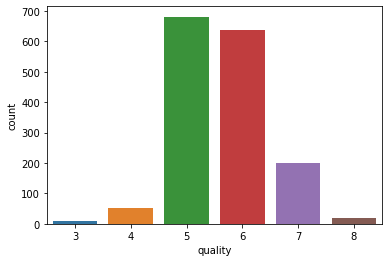

In [ ]:
sns.countplot('quality', data=df)

Let us split the data into X i.e. array of features and y i.e. target variable.

In [ ]:
X = df.iloc[:,0:11]
y = df.iloc[:,11:]

print(X.shape)
print(y.shape)


(1599, 11)
(1599, 1)


In [ ]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [ ]:
y.head()

,quality
0,5
1,5
2,5
3,6
4,5


We will now split the data into train and test with stratification, so that the distribution of classes is maintained in the test data.

We will then keep the test data aside and use train data for training as well as for balancing later.

Note: We will not be balancing the test data, hence will keep it aside.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1279, 11)
(320, 11)
(1279, 1)
(320, 1)


Let's see the distribution of classes in both train data as well as test data:

In [ ]:
train_distribution = y_train.value_counts()
train_distribution
# type(train_distribution) #its pandas

quality
5          545
6          510
7          159
4           42
8           15
3            8
dtype: int64

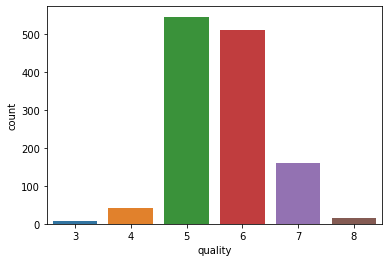

In [ ]:
sns.countplot('quality', data = y_train)

In [ ]:
y_test.value_counts()

quality
5          136
6          128
7           40
4           11
8            3
3            2
dtype: int64

[(0.0, 550.0)]

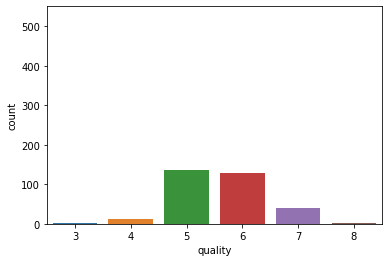

In [ ]:
g = sns.countplot('quality', data = y_test)
g.set(ylim=(0, 550))

#Modeling without balancing


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
rfc = RandomForestClassifier(random_state = 0)
abc = AdaBoostClassifier(random_state = 0)
gbc = GradientBoostingClassifier(random_state = 0)

dt.fit(X_train, y_train)
rfc.fit(X_train, y_train)
abc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

print('Decision Tree score: ', dt.score(X_test, y_test))
print('Random Forest Classifier score: ', rfc.score(X_test, y_test))
print('AdaBoost Classifier score: ', abc.score(X_test, y_test))
print('GradientBoost Classifier score: ', gbc.score(X_test, y_test))




Decision Tree score:  0.634375
Random Forest Classifier score:  0.70625
AdaBoost Classifier score:  0.484375
GradientBoost Classifier score:  0.61875


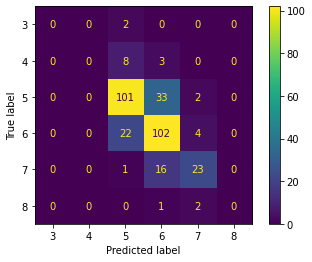

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)

#Applying balancing techniques

The imbalanced datasets are generally biased towards the majority class of the target variable. In this case the classes 5,6,7 are majority classes and rest are minority classes. Hence if we don't balance the classes, the machine learning algorithms will be biased towards the majority classes. 

There are two ways in which we can balance these two categories - 

- **Undersampling**: In undersampling we select some observations of majority class as we have for minority class to make both of these classes balanced. 
Methods available for under sampling in imblearn are
  - Random Under Sampler 
  - Near Miss
  - Tomek Links

- **Oversampling**: In oversampling, we create multiple copies of minority class to have same number of observations as we have for majority class. Here also we can oversampling in two ways - 
  
  Methods for oversampling in imblearn are
  - Random Over Sampler
  - SMOTE
  - BorderlineSMOTE
  - SVMSMOTE
  - SVMSmote
  - ADASYN

- **Combination**: of oversampling and undersampling
  - SMOTE-Tomek Links

Below, we visualize the training samples before we apply any balancing technique. 

Note: For visualization purpose, we have taken two features arbitrarily. You may take any other two features as well.

Text(0.5, 1.0, 'Before balancing')

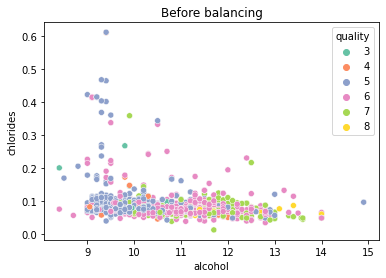

In [ ]:
c= sns.color_palette('Set2',6)
sns.scatterplot(X_train['alcohol'], X_train['chlorides'], hue = y['quality'], palette = c)
plt.title('Before balancing')

##RandomUnderSampler

We will first use RandomUnderSampler. In this method, the majority class(es) are under-sampled by randomly picking samples with or without replacement.

As a matter of practice, it is not advisable to use this methods in case of imbalanced datasets which are smaller in size. This is due to the fact that the model after training on a smaller dataset is not as robust as one trained on large dataset.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

RUS = RandomUnderSampler()
X_RUS, y_RUS, = RUS.fit_resample(X_train, y_train)


In [ ]:
print(X_RUS.shape)
print(y_RUS.shape)
print(y_RUS.value_counts())

(48, 11)
(48, 1)
quality
3          8
4          8
5          8
6          8
7          8
8          8
dtype: int64


Text(0.5, 1.0, 'After RandomUnderSampler')

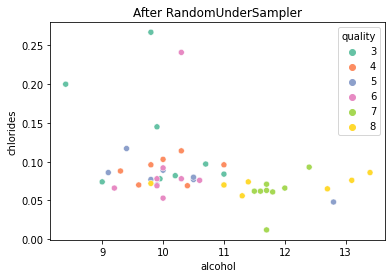

In [ ]:
c= sns.color_palette('Set2',6)
sns.scatterplot(X_RUS['alcohol'], X_RUS['chlorides'], hue = y_RUS['quality'], palette = c)
plt.title('After RandomUnderSampler')

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
rfc = RandomForestClassifier(random_state = 0)
abc = AdaBoostClassifier(random_state = 0)
gbc = GradientBoostingClassifier(random_state = 0)

dt.fit(X_RUS, y_RUS)
rfc.fit(X_RUS, y_RUS)
abc.fit(X_RUS, y_RUS)
gbc.fit(X_RUS, y_RUS)

print('Decision Tree score: ', dt.score(X_test, y_test))
print('Random Forest Classifier score: ', rfc.score(X_test, y_test))
print('AdaBoost Classifier score: ', abc.score(X_test, y_test))
print('GradientBoost Classifier score: ', gbc.score(X_test, y_test))



Decision Tree score:  0.34375
Random Forest Classifier score:  0.321875
AdaBoost Classifier score:  0.053125
GradientBoost Classifier score:  0.3125


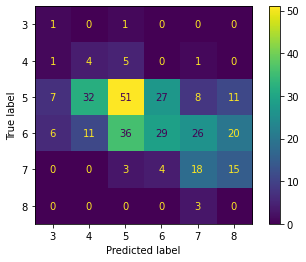

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)

The reason for a very poor score is the very few number of samples for training. Therefore, this technique should only be used if there are a large number of samples in the least-represented class.

##Nearmiss Undersampling

Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.


There are three versions of the technique, named NearMiss-1, NearMiss-2, and NearMiss-3.

NearMiss-1 selects examples from the majority class that have the smallest average distance to the three closest examples from the minority class. NearMiss-2 selects examples from the majority class that have the smallest average distance to the three furthest examples from the minority class. NearMiss-3 involves selecting a given number of majority class examples for each example in the minority class that are closest.

Here, distance is determined in feature space using Euclidean distance

In [ ]:
from imblearn.under_sampling import NearMiss

NM = NearMiss(version = 1)
X_NM, y_NM = NM.fit_resample(X_train, y_train)

In [ ]:
print(X_NM.shape)
print(y_NM.shape)
print(y_NM.value_counts())

(48, 11)
(48, 1)
quality
3          8
4          8
5          8
6          8
7          8
8          8
dtype: int64


Text(0.5, 1.0, 'After Near Miss Undersampler')

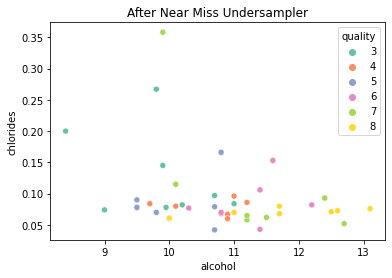

In [ ]:
c= sns.color_palette('Set2',6)
sns.scatterplot(X_NM['alcohol'], X_NM['chlorides'], hue = y_NM['quality'], palette = c)
plt.title('After Near Miss Undersampler')

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
rfc = RandomForestClassifier(random_state = 0)
abc = AdaBoostClassifier(random_state = 0)
gbc = GradientBoostingClassifier(random_state = 0)

dt.fit(X_NM, y_NM)
rfc.fit(X_NM, y_NM)
abc.fit(X_NM, y_NM)
gbc.fit(X_NM, y_NM)

print('Decision Tree score: ', dt.score(X_test, y_test))
print('Random Forest Classifier score: ', rfc.score(X_test, y_test))
print('AdaBoost Classifier score: ', abc.score(X_test, y_test))
print('GradientBoost Classifier score: ', gbc.score(X_test, y_test))



Decision Tree score:  0.09375
Random Forest Classifier score:  0.084375
AdaBoost Classifier score:  0.25
GradientBoost Classifier score:  0.128125


Again, note a very poor performance by the models due to a samll number of samples for training. Again highlights that undersampling should be used if the dataset is large enough. Also note that despite a samll number of samples in training, AdaBoost is giving a decent score, highlighting that in different scenarios, different classifiers may be useful.

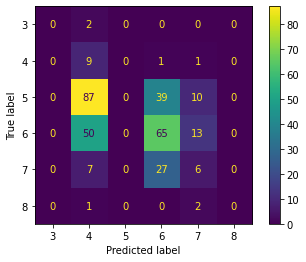

In [ ]:
plot_confusion_matrix(abc, X_test, y_test)

##TomekLinks

Under-sampling by removing Tomek’s links.

Tomek Links are formed by a pair of observations (say, a and b) that fulfill these properties:
- The observation a’s nearest neighbor is b.
- The observation b’s nearest neighbor is a.
- Observation a and b belong to a different class. That is, a and b belong to the minority and majority class (or vice versa), respectively.

This method can be used to find desired samples of data from the majority class that is having the lowest Euclidean distance with the minority class data (i.e. the data from the majority class that is closest with the minority class data, thus make it ambiguous to distinct), and then remove it.

In [ ]:
from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
X_tomek, y_tomek, = tomek.fit_resample(X_train, y_train)

In [ ]:
print(X_tomek.shape)
print(y_tomek.shape)
print(y_tomek.value_counts())

(1036, 11)
(1036, 1)
quality
5          461
6          407
7          123
4           28
8            9
3            8
dtype: int64


Text(0.5, 1.0, 'After TomekLinks Undersampler')

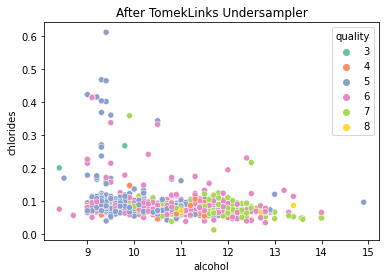

In [ ]:
c= sns.color_palette('Set2',6)
sns.scatterplot(X_tomek['alcohol'], X_tomek['chlorides'], hue = y_tomek['quality'], palette = c)
plt.title('After TomekLinks Undersampler')

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
rfc = RandomForestClassifier(random_state = 0)
abc = AdaBoostClassifier(random_state = 0)
gbc = GradientBoostingClassifier(random_state = 0)

dt.fit(X_tomek, y_tomek)
rfc.fit(X_tomek, y_tomek)
abc.fit(X_tomek, y_tomek)
gbc.fit(X_tomek, y_tomek)

print('Decision Tree score: ', dt.score(X_test, y_test))
print('Random Forest Classifier score: ', rfc.score(X_test, y_test))
print('AdaBoost Classifier score: ', abc.score(X_test, y_test))
print('GradientBoost Classifier score: ', gbc.score(X_test, y_test))




Decision Tree score:  0.58125
Random Forest Classifier score:  0.63125
AdaBoost Classifier score:  0.4875
GradientBoost Classifier score:  0.621875


Since the number of samples have increased, we observe an increase in scores. RandomForest seems to perform the best.

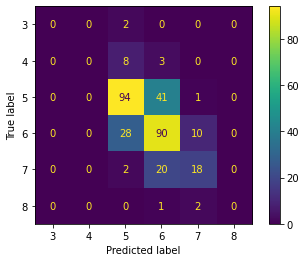

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)

##RandomOverSampler
As the name suggests, the method over samples the minority class(es) by picking samples at random with replacement.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ROS = RandomOverSampler()
X_ROS, y_ROS = ROS.fit_resample(X_train, y_train)

In [ ]:
print(X_ROS.shape)
print(y_ROS.shape)
print(y_ROS.value_counts())

(3270, 11)
(3270, 1)
quality
3          545
4          545
5          545
6          545
7          545
8          545
dtype: int64


Text(0.5, 1.0, 'After RandomOverSampler')

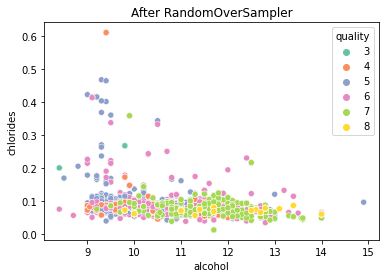

In [ ]:
c= sns.color_palette('Set2',6)
sns.scatterplot(X_ROS['alcohol'], X_ROS['chlorides'], hue = y_ROS['quality'], palette = c)
plt.title('After RandomOverSampler')

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
rfc = RandomForestClassifier(random_state = 0)
abc = AdaBoostClassifier(random_state = 0)
gbc = GradientBoostingClassifier(random_state = 0)

dt.fit(X_ROS, y_ROS)
rfc.fit(X_ROS, y_ROS)
abc.fit(X_ROS, y_ROS)
gbc.fit(X_ROS, y_ROS)

print('Decision Tree score: ', dt.score(X_test, y_test))
print('Random Forest Classifier score: ', rfc.score(X_test, y_test))
print('AdaBoost Classifier score: ', abc.score(X_test, y_test))
print('GradientBoost Classifier score: ', gbc.score(X_test, y_test))




Decision Tree score:  0.58125
Random Forest Classifier score:  0.70625
AdaBoost Classifier score:  0.053125
GradientBoost Classifier score:  0.5875


The minimum score of all is by AdaBoost.

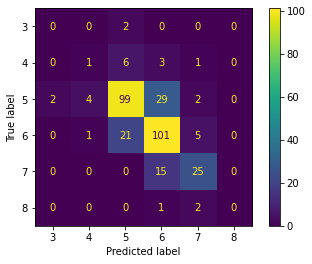

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)

##SMOTE (Synthetic Minority Oversampling Technique)


Here we create observations for the minority class, based on those that already exist. It randomly picks a point from the minority class and finds the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors. The technique works by choosing points that are close, creating a line with these points and generating a new sample at a random location on this line. 

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

The approach is effective because new examples of  minority class that are created are relatively close in feature space to existing examples from the minority class.

A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes.

SMOTE can be used to create as many synthetic examples for the minority class as required. 

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [ ]:
print(X_smote.shape)
print(y_smote.shape)
print(y_smote.value_counts())

(3270, 11)
(3270, 1)
quality
3          545
4          545
5          545
6          545
7          545
8          545
dtype: int64


Text(0.5, 1.0, 'After SMOTE')

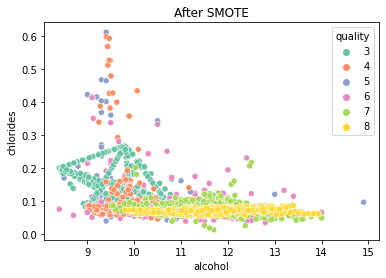

In [ ]:
c= sns.color_palette('Set2',6)
sns.scatterplot(X_smote['alcohol'], X_smote['chlorides'], hue = y_smote['quality'], palette = c)
plt.title('After SMOTE')

Observe the new points added along lines.

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
rfc = RandomForestClassifier(random_state = 0)
abc = AdaBoostClassifier(random_state = 0)
gbc = GradientBoostingClassifier(random_state = 0)

dt.fit(X_smote, y_smote)
rfc.fit(X_smote, y_smote)
abc.fit(X_smote, y_smote)
gbc.fit(X_smote, y_smote)

print('Decision Tree score: ', dt.score(X_test, y_test))
print('Random Forest Classifier score: ', rfc.score(X_test, y_test))
print('AdaBoost Classifier score: ', abc.score(X_test, y_test))
print('GradientBoost Classifier score: ', gbc.score(X_test, y_test))




Decision Tree score:  0.571875
Random Forest Classifier score:  0.6625
AdaBoost Classifier score:  0.284375
GradientBoost Classifier score:  0.559375


In general, RandomForest is scoring the most and AdaBoost the least, so far.

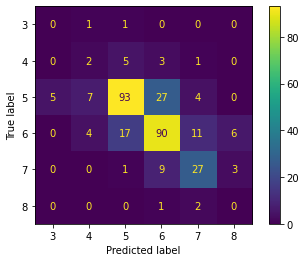

In [ ]:

plot_confusion_matrix(rfc, X_test, y_test)

Note: One of the two samples of class 3 and class 8 each are being correctly classified now after applying SMOTE!!

This is something that we did not observe in unbalanced data as well as with other balancing techniques. Further, although the overall score of RandomForest after SMOTE is lesser than the score obtained using unbalanced data, however,we are seeing an improve in accuracy for underrepesented classes, which is desirable. 

This also highlights looking at the confusion matrix other than the score, while comparing different models.

##BorderlineSMOTE

A popular extension to SMOTE involves selecting those instances of the minority class that are misclassified which are found using k-nearest neighbor classification model.



In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
blsmote = BorderlineSMOTE()

X_blsmote, y_blsmote = blsmote.fit_resample(X_train, y_train)

In [ ]:
print(X_blsmote.shape)
print(y_blsmote.shape)
print(y_blsmote.value_counts())

(3270, 11)
(3270, 1)
quality
3          545
4          545
5          545
6          545
7          545
8          545
dtype: int64


Text(0.5, 1.0, 'After BorderlineSMOTE')

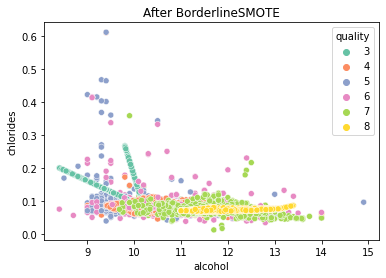

In [ ]:
c= sns.color_palette('Set2',6)
sns.scatterplot(X_blsmote['alcohol'], X_blsmote['chlorides'], hue = y_blsmote['quality'], palette = c)
plt.title('After BorderlineSMOTE')

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
rfc = RandomForestClassifier(random_state = 0)
abc = AdaBoostClassifier(random_state = 0)
gbc = GradientBoostingClassifier(random_state = 0)

dt.fit(X_blsmote, y_blsmote)
rfc.fit(X_blsmote, y_blsmote)
abc.fit(X_blsmote, y_blsmote)
gbc.fit(X_blsmote, y_blsmote)

print('Decision Tree score: ', dt.score(X_test, y_test))
print('Random Forest Classifier score: ', rfc.score(X_test, y_test))
print('AdaBoost Classifier score: ', abc.score(X_test, y_test))
print('GradientBoost Classifier score: ', gbc.score(X_test, y_test))




Decision Tree score:  0.596875
Random Forest Classifier score:  0.703125
AdaBoost Classifier score:  0.29375
GradientBoost Classifier score:  0.55


Borderline SMOTE has resulted in a little better score than plain SMOTE.

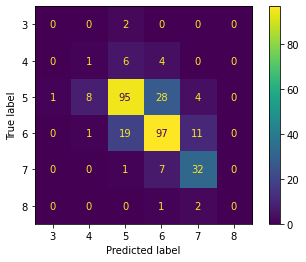

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)

##SVMSmote
An alternative of Borderline-SMOTE where an SVM algorithm is used instead of a KNN to identify misclassified examples on the decision boundary.


##ADASYN (Adaptive Synthetic Sampling Approach)

The difference between SMOTE and ADASYN is the difference in the generation of synthetic sample points for minority data points. In ADASYN, we consider a density distribution which decides the number of synthetic samples to be generated for a particular point (in minority), whereas in SMOTE, there is a uniform weight for all minority points.

In [ ]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='minority')

X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [ ]:
print(X_adasyn.shape)
print(y_adasyn.shape)
print(y_adasyn.value_counts())

(1817, 11)
(1817, 1)
quality
3          546
5          545
6          510
7          159
4           42
8           15
dtype: int64


Text(0.5, 1.0, 'After ADASYN')

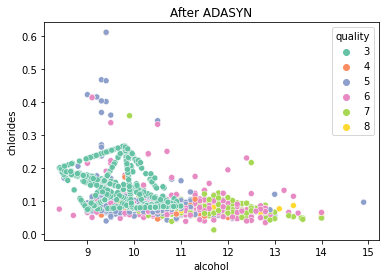

In [ ]:
c= sns.color_palette('Set2',6)
sns.scatterplot(X_adasyn['alcohol'], X_adasyn['chlorides'], hue = y_adasyn['quality'], palette = c)
plt.title('After ADASYN')

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
rfc = RandomForestClassifier(random_state = 0)
abc = AdaBoostClassifier(random_state = 0)
gbc = GradientBoostingClassifier(random_state = 0)

dt.fit(X_adasyn, y_adasyn)
rfc.fit(X_adasyn, y_adasyn)
abc.fit(X_adasyn, y_adasyn)
gbc.fit(X_adasyn, y_adasyn)

print('Decision Tree score: ', dt.score(X_test, y_test))
print('Random Forest Classifier score: ', rfc.score(X_test, y_test))
print('AdaBoost Classifier score: ', abc.score(X_test, y_test))
print('GradientBoost Classifier score: ', gbc.score(X_test, y_test))




Decision Tree score:  0.6125
Random Forest Classifier score:  0.690625
AdaBoost Classifier score:  0.471875
GradientBoost Classifier score:  0.621875


Awesome! ADASYN is leading to >0.71 score by RandomForest.

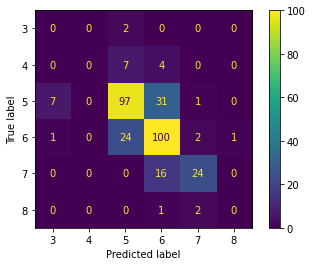

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)

##SMOTE-Tomek Links
This method combines the SMOTE ability to generate synthetic data for minority class and Tomek Links ability to remove the data that are identified as Tomek links from the majority class (that is, samples of data from the majority class that is closest with the minority class data). 

In [ ]:
from imblearn.combine import SMOTETomek

smtom = SMOTETomek(sampling_strategy = 'all')
X_smtm, y_smtm = smtom.fit_resample(X_train, y_train)


In [ ]:
print(X_smtm.shape)
print(y_smtm.shape)
print(y_smtm.value_counts())

(3100, 11)
(3100, 1)
quality
3          544
8          541
7          529
4          523
6          482
5          481
dtype: int64


In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
rfc = RandomForestClassifier(random_state = 0)
abc = AdaBoostClassifier(random_state = 0)
gbc = GradientBoostingClassifier(random_state = 0)

dt.fit(X_smtm, y_smtm)
rfc.fit(X_smtm, y_smtm)
abc.fit(X_smtm, y_smtm)
gbc.fit(X_smtm, y_smtm)

print('Decision Tree score: ', dt.score(X_test, y_test))
print('Random Forest Classifier score: ', rfc.score(X_test, y_test))
print('AdaBoost Classifier score: ', abc.score(X_test, y_test))
print('GradientBoost Classifier score: ', gbc.score(X_test, y_test))





Decision Tree score:  0.584375
Random Forest Classifier score:  0.65625
AdaBoost Classifier score:  0.225
GradientBoost Classifier score:  0.59375


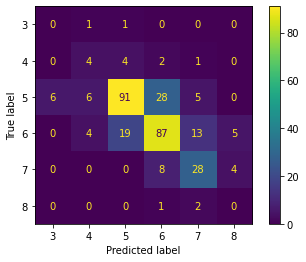

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)

We see that different techniques result in different scores and confusion matrices. While a technique may be useful in one scenario, it may not be as effective in another. This applies to both balancing techniques as well as bagging/boosting techniques.

Note: SMOTE-based algos might have a problem with oversampling extremely scarce class. For example, if we use SVMSMOTE on the given data, it may not work well, as there are some classes with only a few samples in our dataset.